In [1]:
import numpy as np
import math
from pprint import pprint
import matplotlib.pyplot as plt


#### Read the dataset into numpy array

In [2]:
DbigX, Dbigy,Dbig = [], [], []
features=['x1','x2']

with open('Dbig.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            values = line.split(' ')
        else:
            continue
        Dbig.append([float(i) for i in values[:3]])
                   
Dbig=np.array(Dbig)

np.random.shuffle(Dbig)
print(Dbig)      

[[ 1.098132  0.591969  0.      ]
 [ 0.132267  0.987813  0.      ]
 [ 0.986845  1.475199  1.      ]
 ...
 [ 0.784934 -0.175947  0.      ]
 [-0.408622  0.981359  0.      ]
 [-1.289156  1.009479  1.      ]]


In [3]:

def entropy_func(c, n):
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    """
    Returns entropy of a group of data
    c1: count of one class
    c2: count of another class
    """
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c))
        s += e
    return s, n

def get_entropy(y_predict, y_real):
    """
    Returns entropy of a split
    y_predict is the split decision, True/False and y_true can be multi class
    """
    assert len(y_predict) == len(y_real)
    
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

def decisionEntropy(y):
    '''
    calculate total entropy of dataset
    '''
    s = 0
    n = len(y)
    classes = set(y)
    # for each class, calculate entropy
    for c in classes:   
        n_c = sum(y==c)
        e = entropy_func(n_c, n)
        s += e
    return s

In [4]:
class DecisionTreeClassifier(object):
    def __init__(self):
        self.nodeCount=0
        
    def find_best_split(self, col, y):
        ''' find best threshold to split at '''
        max_gain = -math.inf
        n = len(y)
        for value in set(col):
            y_predict = col < value
            info_gain = decisionEntropy(y) - get_entropy(y_predict, y)
            if info_gain >= max_gain:
                max_gain = info_gain
                cutoff = value
        return max_gain, cutoff
    
    def find_best_split_of_all(self, X, y):
        '''find best feature and corresponding best threshold to split at'''
        col = None
        max_info_gain = -math.inf
        cutoff = None
        for i,c in enumerate(X.T):
            max_gain, cur_cutoff = self.find_best_split(c, y)
            if max_gain >= max_info_gain:  # check if it's best so far
                max_info_gain = max_gain
                col = i
                cutoff = cur_cutoff
        return col, cutoff, max_info_gain
    
    def MakeSubtree(self, x, y, par_node={}):
        """
        x: Feature set
        y: target variable
        par_node: will be the tree generated for this x and y. 
        """
        if par_node is None:
            return None
        # No data in the partition
        elif len(y) == 0:   
            return None
        # all y belong to same class
        elif self.all_same(y):   
            return {'val':y[0]}
        # Recursively generate trees
        else:   
            # to count the depth
            self.nodeCount=self.nodeCount+1
            # find one split given an information gain 
            col, cutoff, info_gain = self.find_best_split_of_all(x, y)
            # left branch data
            y_left = y[x[:, col] < cutoff]
            # right branch data
            y_right = y[x[:, col] >= cutoff] 
            # node to attach
            par_node = {'col': features[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y)),'infoGain':info_gain}  
            # generate tree for left branch data
            par_node['then'] = self.MakeSubtree(x[x[:, col] < cutoff], y_left, {})   
            # right hand side trees
            par_node['else'] = self.MakeSubtree(x[x[:, col] >= cutoff], y_right, {})  
            self.trees = par_node  
            return par_node
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
    

    def predict(self, x):
        results = np.array([0]*len(x))
        for i, c in enumerate(x):  
            results[i] = self._get_prediction(c)  
        return results

    def _get_prediction(self, row):
        # get the tree we built during training
        cur_layer = self.trees  
        # if not leaf node
        while cur_layer.get('cutoff'): 
            # get the direction 
            if row[cur_layer['index_col']] < cur_layer['cutoff']:   
                cur_layer = cur_layer['then']
            else:
                cur_layer = cur_layer['else']
        # if leaf node, return value
        else:   
            return cur_layer.get('val')

In [5]:
errorList=[]
nodeCount=[]

def errCal(testY,predResult):
    '''Count errors in the test data'''
    er = 0
    for i, c in enumerate(predResult):
        er = er + (float(c) != float(testY[i]))
    return er

### Create dataset of different sizes

In [6]:
## create train and test datasets
Dtrain=Dbig[0:8192,:]
Dtest=Dbig[8192:10001,:]

# create different sized trainset
D32=Dtrain[0:32,:]
np.savetxt("D32", D32, newline="\n")

D128=Dtrain[0:128,:]
np.savetxt("D128", D128, newline="\n")

D512=Dtrain[0:512,:]
np.savetxt("D512", D512, newline="\n")

D2048=Dtrain[0:2048,:]
np.savetxt("D2048", D2048, newline="\n")

D8192=Dtrain[0:8192,:]
np.savetxt("D8192", D8192, newline="\n")


C32X=D32[:,0:2]
C32y=D32[:,2]

C128X=D128[:,0:2]
C128y=D128[:,2]

C512X=D512[:,0:2]
C512y=D512[:,2]

C2048X=D2048[:,0:2]
C2048y=D2048[:,2]

C8192X=D8192[:,0:2]
C8192y=D8192[:,2]

XBigTrainX = Dtrain[:,0:2]
XbigTrainY = Dtrain[:,2]

XBigTestX = Dtest[:,0:2]
XbigTestY = Dtest[:,2]

### Train and Test DT with different sized dataset

[0.09734513274336283]
[6]


Text(0, 0.5, 'X2')

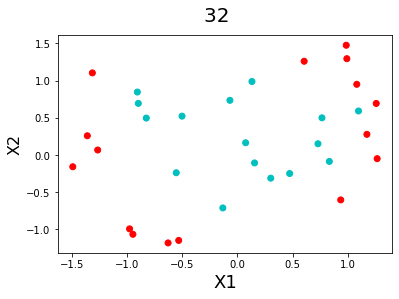

In [7]:
## 32 datapoints
clf = DecisionTreeClassifier()
m32 = clf.MakeSubtree(C32X, C32y)

result = clf.predict( XBigTestX)
errorRate = errCal(XbigTestY,result)
errorList.append(errorRate/len(XbigTestY))
nodeCount.append(clf.nodeCount)
print(errorList)
print(nodeCount)

fig = plt.figure()

plt.scatter(C32X[:,0], C32X[:,1], color=['c' if i==0 else 'r' for i in C32y])
fig.suptitle('32 ', fontsize=20)
plt.xlabel('X1', fontsize=18)
plt.ylabel('X2', fontsize=16)


[0.09734513274336283, 0.084070796460177]
[6, 9]


Text(0, 0.5, 'X2')

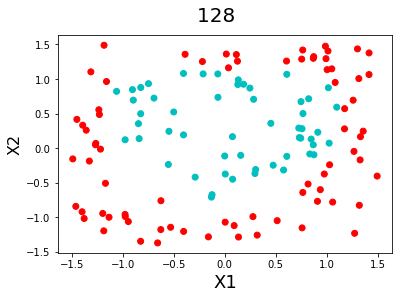

In [8]:
## 128 datapoints

clf = DecisionTreeClassifier()
m128 = clf.MakeSubtree(C128X, C128y)

errorRate = errCal(XbigTestY,clf.predict( XBigTestX))
errorList.append(errorRate/len(XbigTestY))
nodeCount.append(clf.nodeCount)
print(errorList)
print(nodeCount)
fig = plt.figure()

plt.scatter(C128X[:,0], C128X[:,1], color=['c' if i==0 else 'r' for i in C128y])
fig.suptitle('128 ', fontsize=20)
plt.xlabel('X1', fontsize=18)
plt.ylabel('X2', fontsize=16)

[0.09734513274336283, 0.084070796460177, 0.05309734513274336]
[6, 9, 27]


Text(0, 0.5, 'X2')

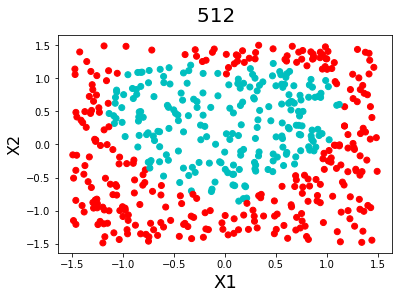

In [9]:
## 512 datapoints

clf = DecisionTreeClassifier()
m512 = clf.MakeSubtree(C512X, C512y)
#pprint(m512)
errorRate = errCal(XbigTestY,clf.predict( XBigTestX))
errorList.append(errorRate/len(XbigTestY))
nodeCount.append(clf.nodeCount)
print(errorList)
print(nodeCount)
fig = plt.figure()

plt.scatter(C512X[:,0], C512X[:,1], color=['c' if i==0 else 'r' for i in C512y])
fig.suptitle('512 ', fontsize=20)
plt.xlabel('X1', fontsize=18)
plt.ylabel('X2', fontsize=16)

[0.09734513274336283, 0.084070796460177, 0.05309734513274336, 0.033185840707964605]
[6, 9, 27, 55]


Text(0, 0.5, 'X2')

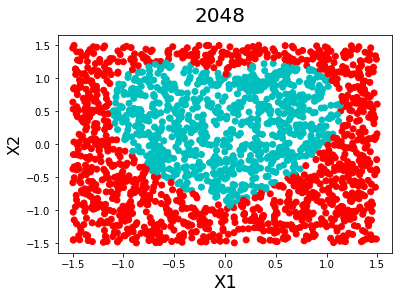

In [10]:
## 2048 datapoints

clf = DecisionTreeClassifier()
m32 = clf.MakeSubtree(C2048X, C2048y)
errorRate = errCal(XbigTestY,clf.predict( XBigTestX))
errorList.append(errorRate/len(XbigTestY))
nodeCount.append(clf.nodeCount)
print(errorList)
print(nodeCount)

fig = plt.figure()

plt.scatter(C2048X[:,0], C2048X[:,1], color=['c' if i==0 else 'r' for i in C2048y])
fig.suptitle('2048', fontsize=20)
plt.xlabel('X1', fontsize=18)
plt.ylabel('X2', fontsize=16)

In [ ]:
## 8192 datapoints

clf = DecisionTreeClassifier()
m32 = clf.MakeSubtree(C8192X, C8192y)
errorRate = errCal(XbigTestY,clf.predict( XBigTestX))
errorList.append(errorRate/len(XbigTestY))
nodeCount.append(clf.nodeCount)
print(errorList)
print(nodeCount)

fig = plt.figure()

plt.scatter(C8192X[:,0], C8192X[:,1], color=['c' if i==0 else 'r' for i in C8192y])
fig.suptitle('8192', fontsize=20)
plt.xlabel('X1', fontsize=18)
plt.ylabel('X2', fontsize=16)

### Plot error v/s number of datapoints curve

In [ ]:
print(errorList)
print(nodeCount)
start_ind=2^5
# n= [32,128,512,2048,8192]
n=[start_ind * 4**i for i in range(0,5)]
print(n)

#node
fig = plt.figure()
plt.plot(n, errorList)


In [ ]:
print(errorList)
print(nodeCount)
n= [32,128,512,2048,8192]
#node
fig = plt.figure()
errList100=[18.14, 8.46, 5.30, 2.43, 1.54]
plt.plot(n, errList100)
plt.ylabel('error rate(percent)', fontsize=18)
plt.xlabel('test set size', fontsize=16)

### Plot Weka results

In [ ]:
np.savetxt("testData.txt", Dtest, newline="\n")

In [ ]:
weka_err=[20.18,8.73,5.91,2.68,1.54]
weka_nodes=[3,8,11,35,69]

fig = plt.figure()
plt.plot(weka_nodes, weka_err)
plt.ylabel('error rate(percent)', fontsize=18)
plt.xlabel('test set size', fontsize=16)



### Small training set where both classes are present but the algorithm refuses to split

In [ ]:
fig = plt.figure()
Xt=np.array([[0, 0],
 [0, 1],
 [1, 0],
 [1, 1]])
yt=np.array([1,0,0,1])

plt.scatter(Xt[:,0], Xt[:,1], color=['c' if i==0 else 'r' for i in yt])
fig.suptitle('', fontsize=20)
plt.xlabel('X1', fontsize=18)
plt.ylabel('X2', fontsize=16)


clfHand = DecisionTreeClassifier()
mclfHand = clfHand.MakeSubtree(Xt, yt)
pprint(mclfHand)